<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [199]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re
import string

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report



from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Otros
# -----------------------------------------------------------------------
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion
import sys
sys.path.append("../../")
from src import soporte_sistemas_recomendacion as sr
from src import soporte_nlp as sn




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [200]:
# Funcion Ana
def limpiar_texto(text):
    if isinstance(text, str):
        text = contractions.fix(text)

        text = text.lower()
        text = re.sub(r"[^\w\s]", "", text)
        text = re.sub(r"\s+", " ", text)
        text = text.strip()
        # doc = nlp(text)


        # tokens = [token.lemma_ for token in doc if token.text not in stop_words]
        return text
    else:
        pass

In [201]:
df = pd.read_csv("../../../datos/datos_fin.csv", index_col=0)

In [202]:
df.dropna(inplace= True)
df.isna().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           0
reviewStar            0
reviewText            0
inconsistentStatus    0
dtype: int64

In [203]:
df_group = result = df.groupby("productName").agg({
    "reviewText": lambda x: ", ".join(str(val) for val in x if pd.notnull(val))  # Concatenar como texto
}).reset_index()


LIMPIEZA DF

In [204]:
dfx = df.copy()
dfx["tags"] = dfx["reviewText"].apply(limpiar_texto)


In [205]:
df_group.dtypes

productName    object
reviewText     object
dtype: object

Sistema de recomendación

In [206]:
df_final = df_group.copy()

In [207]:
df_final.head()

,productName,reviewText
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",I’ll admit I was very skeptical from reviews b...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,"It’s thick, but works good once you get used t..."
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,I was not impressed with the image quality. A...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",The laptop arrived just in time for school!! W...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Bought for school work. Doing good so far.Slee...


In [208]:
nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [209]:
df_final["tags"] = df_final["reviewText"].apply(limpiar_texto)
df_final.head()

,productName,reviewText,tags
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",I’ll admit I was very skeptical from reviews b...,i will admit i was very skeptical from reviews...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,"It’s thick, but works good once you get used t...",it is thick but works good once you get used t...
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,I was not impressed with the image quality. A...,i was not impressed with the image quality als...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",The laptop arrived just in time for school!! W...,the laptop arrived just in time for school wor...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Bought for school work. Doing good so far.Slee...,bought for school work doing good so farsleek ...


In [210]:
productos_unicos = (df_final["productName"].unique())

dic_renaming = {}
for indice,producto in enumerate(productos_unicos):

    dic_renaming[producto] = f"producto_{indice}"


In [211]:
dic_renaming

{'(Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked': 'producto_0',
 'AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml': 'producto_1',
 'AKASO EK7000 4K30FPS Action Camera Ultra HD Underwater Camera 170 Degree Wide Angle 98FT Waterproof Camera': 'producto_2',
 'ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD Display, Intel Celeron N4020 Processor, 4GB RAM, 64GB Storage, NumberPad, Windows 10 Home in S Mode with One Year of Microsoft 365 Personal, L210MA-DB01': 'producto_3',
 'Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6" Full HD IPS | AMD Ryzen 3 3350U Quad-Core Mobile Processor | 4GB DDR4 | 128GB NVMe SSD | WiFi 6 | Backlit KB | Amazon Alexa | Windows 10 Home (S mode)': 'producto_4',
 'Ailun Glass Screen Protector Compatible for iPhone 11/iPhone XR, 6.1 Inch 3 Pack Tempered Glass': 'producto_5',
 'Amazon Basics Ergonomic Office Desk Chair with Armrests, Adjustable Height/Tilt, 360-Degree Swivel, 275Lb Cap

In [212]:
print(len(dic_renaming))

df_final["productName"] = df_final["productName"].replace(dic_renaming)

99


In [213]:
df_final = df_final.drop_duplicates()
df_final.reset_index(inplace=True, drop=True)

In [214]:
df_final.head()

,productName,reviewText,tags
0,producto_0,I’ll admit I was very skeptical from reviews b...,i will admit i was very skeptical from reviews...
1,producto_1,"It’s thick, but works good once you get used t...",it is thick but works good once you get used t...
2,producto_2,I was not impressed with the image quality. A...,i was not impressed with the image quality als...
3,producto_3,The laptop arrived just in time for school!! W...,the laptop arrived just in time for school wor...
4,producto_4,Bought for school work. Doing good so far.Slee...,bought for school work doing good so farsleek ...


In [215]:
df_final["productName"].value_counts()

productName
producto_0     1
producto_1     1
producto_2     1
producto_3     1
producto_4     1
              ..
producto_94    1
producto_95    1
producto_96    1
producto_97    1
producto_98    1
Name: count, Length: 99, dtype: int64

In [216]:
# realizamos la vectorización, es decir, convertimos el texto a vectores para poder calcular las distancias entre películas
vectorizer = CountVectorizer(max_features=1000,stop_words= "english")

# vectorizamos la columna objetivo
X = vectorizer.fit_transform(df_final['tags']).toarray()

# calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:20]

array([[1.        , 0.23318998, 0.40527499, ..., 0.32786986, 0.25128075,
        0.32469897],
       [0.23318998, 1.        , 0.34013107, ..., 0.30958317, 0.28125766,
        0.31732811],
       [0.40527499, 0.34013107, 1.        , ..., 0.4457509 , 0.31245064,
        0.36723023],
       ...,
       [0.19490135, 0.25312553, 0.27320052, ..., 0.25805487, 0.22149941,
        0.22792436],
       [0.27647462, 0.38132012, 0.36337024, ..., 0.37553779, 0.36312579,
        0.35072174],
       [0.21354387, 0.32869453, 0.29115346, ..., 0.28752973, 0.27290549,
        0.26879098]])

In [217]:
df_final.columns

Index(['productName', 'reviewText', 'tags'], dtype='object')

In [218]:
producto_usuario = "producto_17"

# buscamos el inidice de la pelicula, ya que lo vamos a necesitar para nuestro objetivo
product_index = sr.get_index_from_title(producto_usuario,"productName", df_final)

# sacamos las peliculas similares
similar_products = list(enumerate(similarity[product_index]))
similar_products

[(0, np.float64(0.19490134864368885)),
 (1, np.float64(0.25312552633253166)),
 (2, np.float64(0.2732005238071056)),
 (3, np.float64(0.27373092983335834)),
 (4, np.float64(0.25820643878002536)),
 (5, np.float64(0.23361825889094345)),
 (6, np.float64(0.2013992071563508)),
 (7, np.float64(0.19763567302410423)),
 (8, np.float64(0.10104095816657599)),
 (9, np.float64(0.2712014465042992)),
 (10, np.float64(0.2906617532660721)),
 (11, np.float64(0.20699176430944846)),
 (12, np.float64(0.24874470551696962)),
 (13, np.float64(0.2559599604848521)),
 (14, np.float64(0.23639223295423084)),
 (15, np.float64(0.19608731108676203)),
 (16, np.float64(0.22557112188981454)),
 (17, np.float64(1.0)),
 (18, np.float64(0.26895110281229967)),
 (19, np.float64(0.20232905671523577)),
 (20, np.float64(0.221311945713966)),
 (21, np.float64(0.19557866731972773)),
 (22, np.float64(0.18868375495282197)),
 (23, np.float64(0.27141806975321586)),
 (24, np.float64(0.2662385601203063)),
 (25, np.float64(0.307288912533535

In [219]:
# ordenamos los productos
productos_similares_ordenados = sorted(similar_products,key=lambda x:x[1],reverse=True)[1:25]
len(productos_similares_ordenados)

24

In [220]:
productos_similares_ordenados

[(52, np.float64(0.35505432952379407)),
 (30, np.float64(0.3362404533671613)),
 (31, np.float64(0.3344621882101484)),
 (25, np.float64(0.3072889125335355)),
 (91, np.float64(0.30116118900622835)),
 (54, np.float64(0.2991746161191592)),
 (51, np.float64(0.2950134049053018)),
 (81, np.float64(0.2917081963526702)),
 (10, np.float64(0.2906617532660721)),
 (43, np.float64(0.2888711273456184)),
 (72, np.float64(0.28834375113814487)),
 (94, np.float64(0.2882358721003378)),
 (50, np.float64(0.28059850780464124)),
 (48, np.float64(0.28007266377606055)),
 (63, np.float64(0.2741148816014687)),
 (3, np.float64(0.27373092983335834)),
 (2, np.float64(0.2732005238071056)),
 (35, np.float64(0.2728466605144651)),
 (38, np.float64(0.27240714650051345)),
 (77, np.float64(0.2718678344017573)),
 (23, np.float64(0.27141806975321586)),
 (9, np.float64(0.2712014465042992)),
 (67, np.float64(0.2703543444290068)),
 (18, np.float64(0.26895110281229967))]

C:\Users\Victor\AppData\Local\Temp\ipykernel_8844\1668503152.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


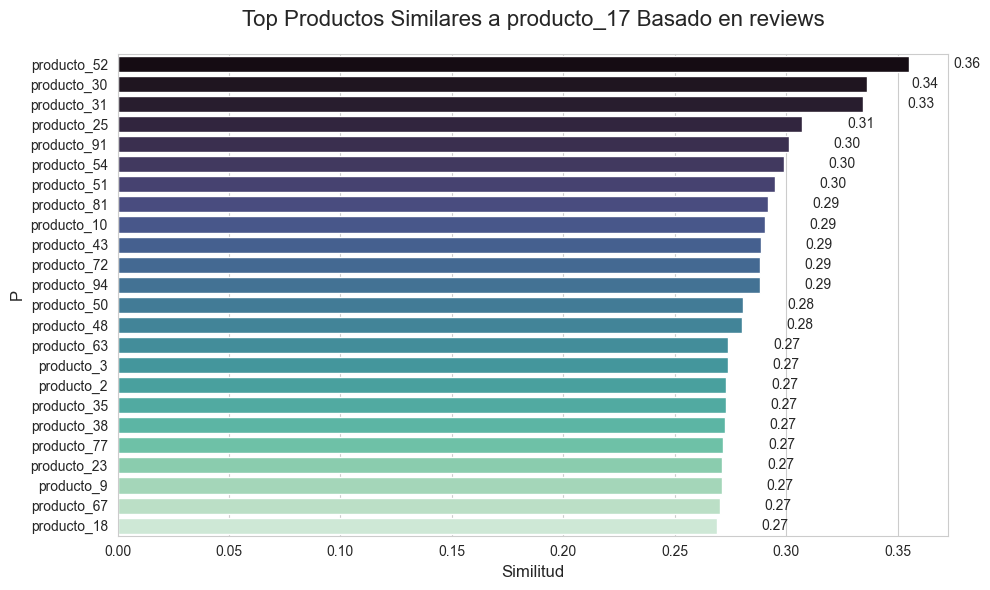

In [221]:
# y ahora buscamos el título
top_similar_products = {}
for i in productos_similares_ordenados:
    top_similar_products[sr.get_title_from_index(i[0],column_name="productName", dataframe= df_final)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_similar_products.values()), 
    y=list(top_similar_products.keys()), 
    palette="mako"
)

# Añadir etiquetas y título
plt.title(f"Top Productos Similares a {producto_usuario} Basado en reviews", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("P", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_similar_products.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()


# Parte 2


## Analisis de sentimientos

In [239]:
df3 = dfx.copy()

graficamos sentimientos

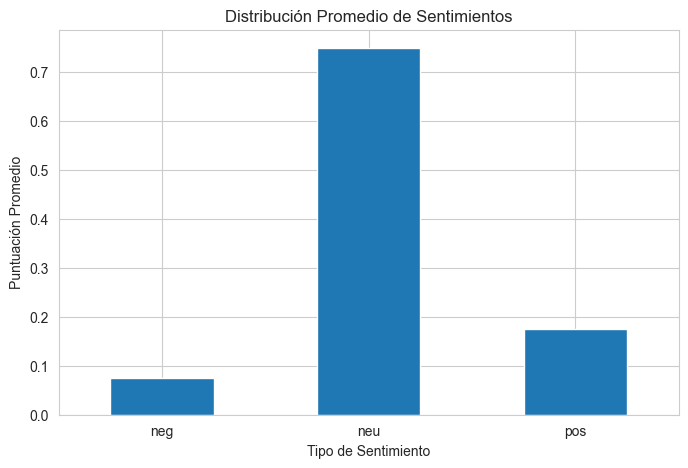

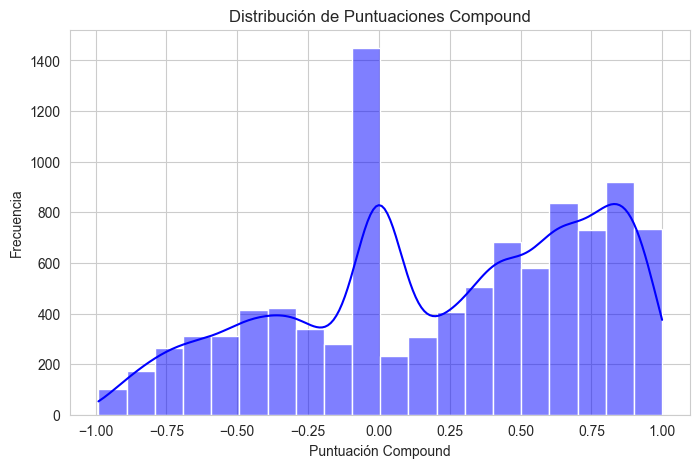

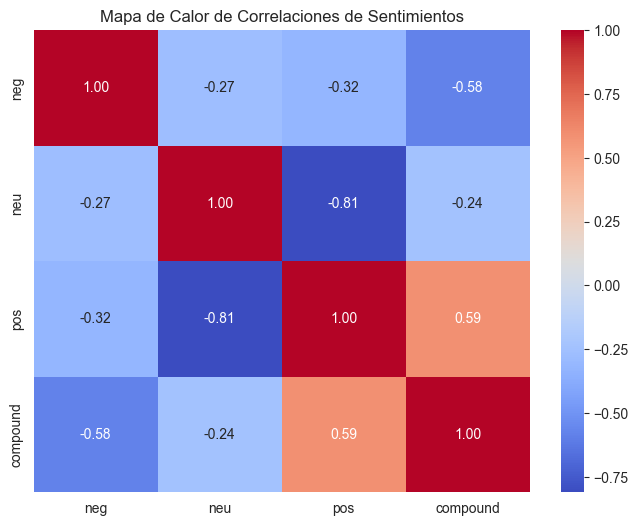

In [240]:
analisis_sentimientos = sn.AnalisisSentimientos(df3, columna_texto='tags')

# Generar gráficos
analisis_sentimientos.graficar_distribucion_sentimientos()
analisis_sentimientos.graficar_distribucion_compound()
analisis_sentimientos.graficar_mapa_calor_sentimientos()

In [241]:
df_scores = df3["tags"].apply(lambda x: pd.Series(analisis_sentimientos._analizar_texto(x)))

In [242]:
df3 = pd.concat([df3,df_scores], axis = 1)

In [243]:
df3.sample(10)

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,tags,neg,neu,pos,compound
30511,R3E9IK1B90R27R,"Reviewed in the United States on August 26, 2021",Electronics,CellPhones and Accessories,Ailun Glass Screen Protector Compatible for iP...,Wet wipes are dry,2.0,Wouldn’t buy again because were wipes are dry....,1,would not buy again because were wipes are dry...,0.000,0.876,0.124,0.4019
27527,R3HIJ66960AY9O,"Reviewed in the United States on August 28, 2021",Electronics,Camera and Accessories,Blink Mini – Compact indoor plug-in smart secu...,Don’t work !,1.0,Spent hours fighting with this piece of junk a...,0,spent hours fighting with this piece of junk a...,0.098,0.902,0.000,-0.3612
52949,R27013CGFYPU9F,"Reviewed in the United States on July 8, 2021",Computers,Men's Accessories,Goorin Bros. Men's Animal Farm Snap Back Truck...,FAKE!,1.0,FAKE!,0,fake,1.000,0.000,0.000,-0.4767
35394,R24LC0GJI45IN9,"Reviewed in the United States on May 11, 2021",Electronics,Headphones,"Samsung Galaxy Buds Plus, True Wireless Earbud...",Right Bud stopped working.,1.0,Right one stopped working after about 9 months...,0,right one stopped working after about 9 months...,0.101,0.899,0.000,-0.2263
34377,R2SVLKHBX9WA6P,"Reviewed in the United States on May 27, 2021",Electronics,GPS and Navigation,Tracki 2021 Model Mini Real time GPS Tracker. ...,Overall,4.0,I got this device since my wife had to drive/w...,0,i got this device since my wife had to drivewa...,0.000,0.903,0.097,0.7003
15036,RRVYL77BNFIVB,"Reviewed in the United States on August 9, 2021",Computers,Computer Accessories & Peripherals,"seenda Wireless Mouse, 2.4G Noiseless Mouse wi...",Stay away,1.0,My box was open all I received was the mouse n...,1,my box was open all i received was the mouse n...,0.000,1.000,0.000,0.0000
58264,RU01CL28JEYO7,"Reviewed in the United States on March 23, 2020",Computers,Men's Shoes,New Balance Men's 623 V3 Casual Comfort Cross ...,Don’t recommend,2.0,My husband works in law enforcement with a sof...,0,my husband works in law enforcement with a sof...,0.054,0.946,0.000,-0.5096
49756,R270IHP6F7AYHF,"Reviewed in the United States on July 17, 2021",Home and Kitchen,"Heating, Cooling & Air Quality",Portable Electric Space Heater with Thermostat...,Great heater and fan combo,5.0,Working in an office the temperature is never ...,0,working in an office the temperature is never ...,0.018,0.751,0.231,0.9346
37244,RD87GAS2TY1NI,"Reviewed in the United States on August 24, 2021",Electronics,Headphones,"Samsung Galaxy Buds Plus, True Wireless Earbud...",Great earbuds,5.0,Very happy with my purchase. Got these when th...,0,very happy with my purchase got these when the...,0.038,0.864,0.097,0.7610
36923,R3FQSB7W8YAOHZ,"Reviewed in the United States on August 16, 2021",Electronics,Headphones,iJoy Matte Finish Premium Rechargeable Wireles...,Great for the price,4.0,For inexpensive headphones they’re great!,0,for inexpensive headphones they are great,0.000,0.549,0.451,0.6249


In [244]:
def traducir_sentimiento (compound):
    if compound < 0.1:
        return "Negativo"
    elif compound >= 0.1 and compound <= 0.3:
        return "Neutral"
    elif compound > 0.3:
        return "Positivo"

In [ ]:
df3["Sentimiento"] = df3["compound"].apply(traducir_sentimiento)

Generamos embeddings

In [263]:
df2 = df_final.copy()

In [261]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
embedding_model = AutoModel.from_pretrained("bert-base-uncased")

embeddings = []

for text in df2["tags"]:
    inputs = tokenizer(text,return_tensors = "pt", truncation = True, padding = True, max_length = 512)

    with torch.no_grad():
        outputs = embedding_model(**inputs)
    
    embeddings.append(outputs.last_hidden_state.mean(dim = 1).squeeze().numpy())

embeddings_df = pd.DataFrame(embeddings, columns=[f"embedding_{i}" for i in range (embeddings[0].shape[0])])
df_embeddings = pd.concat([df2.reset_index(drop = True), embeddings_df], axis = 1)

KeyError: 'tags'

In [ ]:
df_embeddings.head()

,productName,reviewText,tags,neg,neu,pos,compound,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,embedding_11,embedding_12,embedding_13,embedding_14,embedding_15,embedding_16,embedding_17,embedding_18,embedding_19,embedding_20,embedding_21,embedding_22,embedding_23,embedding_24,embedding_25,embedding_26,embedding_27,embedding_28,embedding_29,embedding_30,embedding_31,embedding_32,embedding_33,embedding_34,embedding_35,embedding_36,embedding_37,embedding_38,embedding_39,embedding_40,embedding_41,embedding_42,embedding_43,embedding_44,embedding_45,embedding_46,embedding_47,embedding_48,embedding_49,embedding_50,embedding_51,embedding_52,embedding_53,embedding_54,embedding_55,embedding_56,embedding_57,embedding_58,embedding_59,embedding_60,embedding_61,embedding_62,embedding_63,embedding_64,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74,embedding_75,embedding_76,embedding_77,embedding_78,embedding_79,embedding_80,embedding_81,embedding_82,embedding_83,embedding_84,embedding_85,embedding_86,embedding_87,embedding_88,embedding_89,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,embedding_101,embedding_102,embedding_103,embedding_104,embedding_105,embedding_106,embedding_107,embedding_108,embedding_109,embedding_110,embedding_111,embedding_112,embedding_113,embedding_114,embedding_115,embedding_116,embedding_117,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,embedding_128,embedding_129,embedding_130,embedding_131,embedding_132,embedding_133,embedding_134,embedding_135,embedding_136,embedding_137,embedding_138,embedding_139,embedding_140,embedding_141,embedding_142,embedding_143,embedding_144,embedding_145,embedding_146,embedding_147,embedding_148,embedding_149,embedding_150,embedding_151,embedding_152,embedding_153,embedding_154,embedding_155,embedding_156,embedding_157,embedding_158,embedding_159,embedding_160,embedding_161,embedding_162,embedding_163,embedding_164,embedding_165,embedding_166,embedding_167,embedding_168,embedding_169,embedding_170,embedding_171,embedding_172,embedding_173,embedding_174,embedding_175,embedding_176,embedding_177,embedding_178,embedding_179,embedding_180,embedding_181,embedding_182,embedding_183,embedding_184,embedding_185,embedding_186,embedding_187,embedding_188,embedding_189,embedding_190,embedding_191,embedding_192,embedding_193,embedding_194,embedding_195,embedding_196,embedding_197,embedding_198,embedding_199,embedding_200,embedding_201,embedding_202,embedding_203,embedding_204,embedding_205,embedding_206,embedding_207,embedding_208,embedding_209,embedding_210,embedding_211,embedding_212,embedding_213,embedding_214,embedding_215,embedding_216,embedding_217,embedding_218,embedding_219,embedding_220,embedding_221,embedding_222,embedding_223,embedding_224,embedding_225,embedding_226,embedding_227,embedding_228,embedding_229,embedding_230,embedding_231,embedding_232,embedding_233,embedding_234,embedding_235,embedding_236,embedding_237,embedding_238,embedding_239,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249,embedding_250,embedding_251,embedding_252,embedding_253,embedding_254,embedding_255,embedding_256,embedding_257,embedding_258,embedding_259,embedding_260,embedding_261,embedding_262,embedding_263,embedding_264,embedding_265,embedding_266,embedding_267,embedding_268,embedding_269,embedding_270,embedding_271,embedding_272,embedding_273,embedding_274,embedding_275,embedding_276,embedding_277,embedding_278,embedding_279,embedding_280,embedding_281,embedding_282,embedding_283,embedding_284,embedding_285,embedding_286,embedding_287,embedding_288,embedding_289,

In [ ]:
df_embeddings.shape

(99, 775)

PCA

In [ ]:
embeddings_reducidos

array([[ 0.3773043 ,  0.88377756, -0.45082897, ...,  0.19354808,
        -0.04729482, -0.13503765],
       [ 1.0830421 , -0.90702415, -0.13387132, ..., -0.10130194,
        -0.17128508, -0.14129129],
       [ 0.38256764,  0.75125355, -0.66055894, ..., -0.25723487,
         0.03253078,  0.28671083],
       ...,
       [ 0.2104031 ,  0.39551383,  0.23637813, ...,  0.08258323,
         0.05911295, -0.02923901],
       [ 0.9230354 ,  0.29913184,  0.14715588, ...,  0.14842989,
        -0.32693642, -0.00769861],
       [ 0.18025431,  0.46289337, -1.0729384 , ...,  0.06526364,
        -0.12530085,  0.1557187 ]], dtype=float32)

In [ ]:
from sklearn.decomposition import PCA

columnas_embeddings = df_embeddings.columns.difference(["productName","reviewText","tags"])


pca = PCA(n_components=50)
embeddings_reducidos = pca.fit_transform(df_embeddings[columnas_embeddings].values)


nuevas_columnas = [f"embedding_reducido_{i}" for i in range(50)] 
df_reducido = pd.DataFrame(embeddings_reducidos, columns = nuevas_columnas, index = df_embeddings.index)

df_resto = df_embeddings.drop(columns = columnas_embeddings)
df_fin = pd.concat([df_resto, df_reducido], axis = 1)

In [ ]:
df_fin.head()

,productName,reviewText,tags,embedding_reducido_0,embedding_reducido_1,embedding_reducido_2,embedding_reducido_3,embedding_reducido_4,embedding_reducido_5,embedding_reducido_6,embedding_reducido_7,embedding_reducido_8,embedding_reducido_9,embedding_reducido_10,embedding_reducido_11,embedding_reducido_12,embedding_reducido_13,embedding_reducido_14,embedding_reducido_15,embedding_reducido_16,embedding_reducido_17,embedding_reducido_18,embedding_reducido_19,embedding_reducido_20,embedding_reducido_21,embedding_reducido_22,embedding_reducido_23,embedding_reducido_24,embedding_reducido_25,embedding_reducido_26,embedding_reducido_27,embedding_reducido_28,embedding_reducido_29,embedding_reducido_30,embedding_reducido_31,embedding_reducido_32,embedding_reducido_33,embedding_reducido_34,embedding_reducido_35,embedding_reducido_36,embedding_reducido_37,embedding_reducido_38,embedding_reducido_39,embedding_reducido_40,embedding_reducido_41,embedding_reducido_42,embedding_reducido_43,embedding_reducido_44,embedding_reducido_45,embedding_reducido_46,embedding_reducido_47,embedding_reducido_48,embedding_reducido_49
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",I’ll admit I was very skeptical from reviews b...,admit skeptical review decide purchase anyway ...,0.378976,0.886200,-0.449560,0.036851,-0.124748,-0.245172,0.043188,-0.129036,-0.293749,0.034723,0.452255,-0.057233,-0.022075,0.288002,-0.006408,-0.320242,0.251344,-0.202001,0.332012,-0.293923,0.305043,0.061239,0.097277,-0.404648,-0.074316,-0.047921,-0.097288,0.336721,-0.126399,0.235991,0.206086,-0.101861,0.029840,-0.173417,-0.260534,0.098247,-0.230313,0.206157,0.308019,-0.195396,0.285733,0.130215,-0.063672,-0.120770,-0.438205,0.222297,-0.212119,0.205977,-0.024932,-0.072761
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,"It’s thick, but works good once you get used t...",thick work good get use base top coat work gre...,1.084247,-0.907576,-0.132234,0.052884,0.437545,0.035682,-0.340503,-0.116067,-0.455119,0.204774,0.327070,-0.018578,-0.543732,0.030548,0.305597,0.484730,0.006008,0.089304,-0.001743,-0.570461,0.230423,-0.489698,-0.152089,0.367375,0.151424,0.172692,0.032428,0.007488,0.086345,-0.114422,0.007178,0.474041,0.165598,-0.025771,-0.142309,0.331878,0.399116,0.068313,-0.028186,0.159664,-0.334497,0.283109,0.436821,0.071222,0.113344,-0.191094,0.083802,-0.042712,-0.183759,0.097323
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,I was not impressed with the image quality. A...,impressed image quality also app suggest use p...,0.385056,0.752599,-0.657831,-0.260979,-0.005682,-0.626248,-0.082894,0.383134,0.077117,-0.157754,0.383801,-0.089933,0.261560,0.475317,0.079927,-0.509239,0.182944,-0.244099,-0.056642,0.166293,-0.034373,-0.088862,0.483507,0.345533,-0.121152,0.054889,0.058901,0.078283,0.098780,-0.089035,0.524532,0.522927,0.115193,0.054537,0.176323,-0.134832,0.169991,-0.125352,-0.048192,-0.241074,-0.189326,0.243574,0.263417,0.474919,-0.058450,-0.289635,0.040901,-0.204056,-0.054632,0.028524
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",The laptop arrived just in time for school!! W...,laptop arrive time school work great product d...,-0.302488,1.228517,-0.102511,0.407846,-0.169561,-0.003369,-0.236181,-0.006700,-0.043813,0.160840,-0.323755,-0.461219,-0.220505,-0.177191,-0.356423,0.061479,0.099162,-0.127944,-0.232855,0.301854,-0.095056,0.073240,0.175046,0.022809,-0.178655,-0.241172,0.122994,0.237005,-0.305530,-0.024670,-0.199346,0.154261,-0.260745,0.180772,-0.147985,-0.035045,0.191760,0.174789,-0.121825,-0.267040,0.341226,0.221467,0.153375,-0.251605,0.329406,0.075890,-0.103982,-0.298271,-0.012746,-0.108896
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Bought for school work. Doing good so far.Slee...,buy school work good farsleek alright buy lapt...,-0.204548,1.195739,-1.064875,0.164341,-0.144142,0.493001,-0.230107,-0.276484,-0.255024,0.129773,-0.016463,-0.300722,-0.129278,-0.081122,-0.073329,-0.290248,-0.015085,-0.219704,-0.137390,0.084090,-0.034139,-0.286795

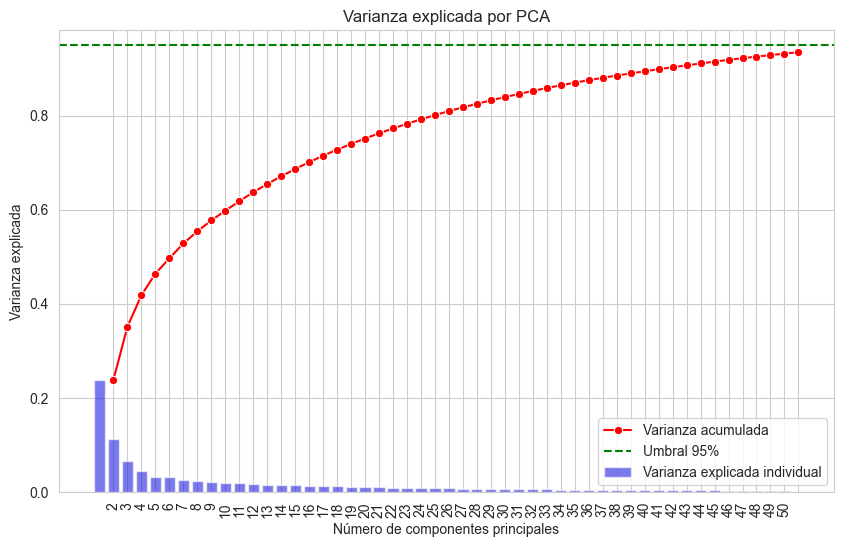

In [ ]:
varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = varianza_explicada.cumsum()

componentes = range(1, len(varianza_acumulada) + 1)
plt.figure(figsize=(10, 6))
sns.barplot(x=componentes, y=varianza_explicada, alpha=0.6, label="Varianza explicada individual", color="b")
sns.lineplot(x=componentes, y=varianza_acumulada, marker='o', label="Varianza acumulada", color="r")
plt.axhline(y=0.95, color='g', linestyle='--', label="Umbral 95%")
plt.title("Varianza explicada por PCA")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza explicada")
plt.xticks(componentes, rotation = 90)
plt.legend()
plt.grid(True)
plt.show()

Clasificamos

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

NameError: name 'y' is not defined

In [ ]:
df_fin.head()

,productName,reviewText,tags,embedding_reducido_0,embedding_reducido_1,embedding_reducido_2,embedding_reducido_3,embedding_reducido_4,embedding_reducido_5,embedding_reducido_6,embedding_reducido_7,embedding_reducido_8,embedding_reducido_9,embedding_reducido_10,embedding_reducido_11,embedding_reducido_12,embedding_reducido_13,embedding_reducido_14,embedding_reducido_15,embedding_reducido_16,embedding_reducido_17,embedding_reducido_18,embedding_reducido_19,embedding_reducido_20,embedding_reducido_21,embedding_reducido_22,embedding_reducido_23,embedding_reducido_24,embedding_reducido_25,embedding_reducido_26,embedding_reducido_27,embedding_reducido_28,embedding_reducido_29,embedding_reducido_30,embedding_reducido_31,embedding_reducido_32,embedding_reducido_33,embedding_reducido_34,embedding_reducido_35,embedding_reducido_36,embedding_reducido_37,embedding_reducido_38,embedding_reducido_39,embedding_reducido_40,embedding_reducido_41,embedding_reducido_42,embedding_reducido_43,embedding_reducido_44,embedding_reducido_45,embedding_reducido_46,embedding_reducido_47,embedding_reducido_48,embedding_reducido_49
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",I’ll admit I was very skeptical from reviews b...,admit skeptical review decide purchase anyway ...,0.377304,0.883778,-0.450829,0.040423,-0.126253,-0.241480,-0.034029,-0.125277,0.288552,-0.096812,-0.453706,-0.042878,-0.103308,-0.298926,-0.060146,-0.391511,0.085013,-0.144146,0.318320,-0.288704,0.305080,0.038295,-0.101313,-0.446413,-0.068295,0.063051,0.323020,-0.002067,-0.106346,0.266401,-0.167454,-0.103054,0.049752,-0.172830,-0.263566,-0.148314,-0.025189,0.186018,-0.375767,-0.374731,0.044087,0.107280,-0.252918,-0.308324,0.121803,-0.307464,0.028122,0.193548,-0.047295,-0.135038
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,"It’s thick, but works good once you get used t...",thick work good get use base top coat work gre...,1.083042,-0.907024,-0.133871,0.060190,0.437214,0.037148,0.370091,-0.080775,0.462661,-0.271315,-0.248377,-0.106446,0.448247,-0.398330,0.181437,0.452042,0.036307,0.079304,0.008981,-0.575445,0.223800,-0.441997,0.253475,0.448643,0.038959,0.087426,0.011436,-0.044205,0.053836,-0.115953,-0.066390,0.473570,0.209183,0.025727,-0.184899,-0.163368,-0.359241,-0.206216,0.168253,0.340512,-0.290852,0.409275,0.208532,0.157996,0.105579,0.186304,0.058233,-0.101302,-0.171285,-0.141291
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,I was not impressed with the image quality. A...,impressed image quality also app suggest use p...,0.382568,0.751254,-0.660559,-0.259685,-0.008473,-0.631969,0.052759,0.378700,-0.121089,0.020758,-0.416631,-0.043320,-0.476501,-0.249131,0.089781,-0.527806,0.069532,-0.255846,-0.054053,0.168613,-0.035524,-0.194509,-0.520132,0.250089,0.106927,0.048062,0.085348,0.110756,0.260359,0.027591,-0.468547,0.513688,0.108310,0.061704,0.174661,0.159168,-0.055577,-0.223224,0.206146,-0.105081,-0.154440,0.348570,0.396208,-0.236414,0.133386,0.209673,0.085223,-0.257235,0.032531,0.286711
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",The laptop arrived just in time for school!! W...,laptop arrive time school work great product d...,-0.307775,1.225835,-0.100004,0.400611,-0.169024,-0.007514,0.228452,-0.003028,0.090173,-0.021934,0.344916,-0.505842,0.176905,0.153636,-0.345703,0.042098,0.083539,-0.189637,-0.208362,0.303285,-0.091013,0.032848,-0.210261,-0.045837,0.087023,-0.273074,0.249986,0.070170,-0.357456,-0.085705,0.084992,0.147114,-0.266864,0.173714,-0.141416,0.121121,-0.188513,0.101117,0.112342,-0.354941,0.123672,0.252218,-0.059918,0.497558,-0.052410,-0.129490,-0.158704,-0.251898,-0.075296,-0.055868
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Bought for school work. Doing good so far.Slee...,buy school work good farsleek alright buy lapt...,-0.208848,1.191950,-1.063383,0.159824,-0.141842,0.492477,0.252236,-0.261129,0.278661,-0.052269,0.028953,-0.321365,0.091033,0.068270,-0.049513,-0.292705,-0.084143,-0.212631,-0.128181,0.082576,-0.036325,-0.294946,0